In [ ]:
!pip install tensorflow-model-optimization

     |████████████████████████████████| 174kB 2.8MB/s 
     |████████████████████████████████| 296kB 8.5MB/s 


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity

from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Reshape, Input, InputLayer, Flatten, ReLU
from tensorflow.keras import models, layers, datasets
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.initializers import RandomNormal

from sklearn.metrics import accuracy_score, precision_score, recall_score

In [ ]:
#param/hyperpapram
batch_size=64
num_classes=10 #CIFAR10
num_epochs=145

#laod dataset
img_rows,img_cols=32,32
(X_train,Y_train),(X_test,Y_test)=tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
print(tf.keras.backend.image_data_format())
X_train=X_train.reshape(X_train.shape[0],img_rows,img_cols,3)
X_test=X_test.reshape(X_test.shape[0],img_rows,img_cols,3)
input_shape=(img_rows,img_cols,3)

print('Input Shape to NN:',input_shape)

channels_last
Input Shape to NN: (32, 32, 3)


In [ ]:
#convert datasets to floating point vecs and normalize
X_train=X_train.astype('float32')
X_test=X_test.astype('float32')
X_train/=255.0
X_test/=255.0

In [ ]:
#one hot encoding
Y_train=tf.keras.utils.to_categorical(Y_train,num_classes)
Y_test=tf.keras.utils.to_categorical(Y_test,num_classes)

In [ ]:
print('Dims')
print('X',X_train.shape,X_test.shape)
print('Y',Y_train.shape,Y_test.shape)

Dims
X (50000, 32, 32, 3) (10000, 32, 32, 3)
Y (50000, 10) (10000, 10)


In [ ]:
#training and testing datasets for GradientTape Training
train_dataset=tf.data.Dataset.from_tensor_slices((X_train,Y_train))
test_dataset=tf.data.Dataset.from_tensor_slices((X_test,Y_test))

In [ ]:
train_dataset=train_dataset.shuffle(buffer_size=20000,reshuffle_each_iteration=True).batch(batch_size=batch_size,drop_remainder=False)

In [ ]:
test_dataset=test_dataset.batch(batch_size=batch_size,drop_remainder=False)

In [ ]:
#params -- opt and loss
lr=0.01
momentum=0.9

loss_fn=tf.keras.losses.CategoricalCrossentropy()
optimizer=tf.keras.optimizers.SGD(learning_rate=lr,momentum=momentum)

In [ ]:
train_loss=tf.keras.metrics.Mean(name='train_loss')
train_accuracy=tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss=tf.keras.metrics.Mean(name='test_loss')
test_accuracy=tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [ ]:
#pruned NN (ref. paper)
def pruned_nn():
  l=tf.keras.layers
  model=Sequential()
  model.add(Conv2D(filters = 64, kernel_size = (3, 3),activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same',
            input_shape=(32, 32, 3)))
  model.add(Conv2D(filters = 64, kernel_size = (3, 3),activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'))
  model.add(MaxPooling2D(pool_size = (2, 2),strides = (2, 2)))
  model.add(Conv2D(filters = 128, kernel_size = (3, 3),activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'))
  model.add(Conv2D(filters = 128, kernel_size = (3, 3),activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'))
  model.add(MaxPooling2D(pool_size = (2, 2),strides = (2, 2)))
  model.add(Conv2D(filters = 256, kernel_size = (3, 3),activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'))
  model.add(Conv2D(filters = 256, kernel_size = (3, 3),activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'))
  model.add(Conv2D(filters = 256, kernel_size = (3, 3),activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'))
  model.add(Conv2D(filters = 256, kernel_size = (3, 3),activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'))
  model.add(MaxPooling2D(pool_size = (2, 2),strides = (2, 2)))
  model.add(Conv2D(filters = 512, kernel_size = (3, 3),activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'))
  model.add(Conv2D(filters = 512, kernel_size = (3, 3),activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'))
  model.add(Conv2D(filters = 512, kernel_size = (3, 3),activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'))
  model.add(Conv2D(filters = 512, kernel_size = (3, 3),activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'))
  model.add(MaxPooling2D(pool_size = (2, 2),strides = (2, 2)))
  model.add(Conv2D(filters = 512, kernel_size = (3, 3),activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'))
  model.add(Conv2D(filters = 512, kernel_size = (3, 3),activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'))
  model.add(Conv2D(filters = 512, kernel_size = (3, 3),activation='relu', kernel_initializer = tf.initializers.he_normal(),
            strides = (1, 1), padding = 'same'))
  model.add(Conv2D(filters = 512, kernel_size = (3, 3),activation='relu', kernel_initializer = tf.initializers.he_normal(),
           strides = (1, 1), padding = 'same'))
  model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))
    
  model.add(Flatten())
  model.add(Dense(units = 10, activation='softmax'))
    
    
    
  model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
        metrics=['accuracy']
    )
    
  return model

In [ ]:
#add pruning callback
callback=[
          sparsity.UpdatePruningStep(),
          tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,min_delta=0.001)
]

In [ ]:
pruned_model=pruned_nn()
pruned_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 256)        

In [ ]:
#train CNN with early stopping
'''
Train model once without early stopping (comment line 14)
  Results:
    Min val_loss was observed after 7th epoch (for first 10 epochs)
    -> Depends on instance
Train model with early stopping (uncomment line 14)
'''
history=orig_model.fit(
    x=X_train,y=Y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    verbose=1,
    callbacks=callback,
    validation_data=(X_test,Y_test),
    shuffle=True
)

Epoch 1/145
 16/782 [..............................] - ETA: 1:45:47 - loss: 2.3001 - accuracy: 0.1035

KeyboardInterrupt: ignored

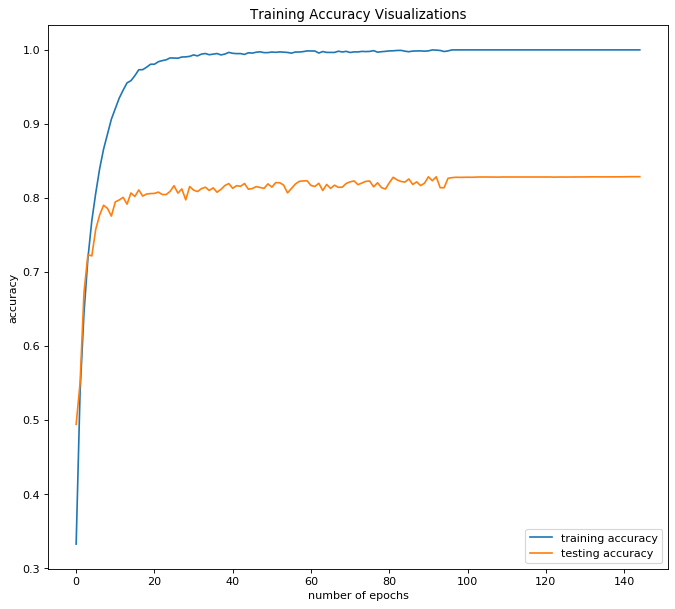

In [15]:
history.history.keys()
fig=plt.figure(figsize=(10, 9), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='testing accuracy')
plt.title('Training Accuracy Visualizations')
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend(loc='best')
plt.show()


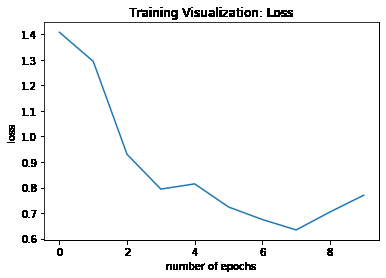

In [14]:
plt.plot(history.history['val_loss'][:10], label = '')
plt.xlabel("number of epochs")
plt.ylabel("loss")
plt.title("Training Visualization: Loss")
plt.show()

In [2]:
history.history['val_loss'][:10]


[1.408210733795166,
 1.2942153066635131,
 0.9301085735321045,
 0.7939510309219361,
 0.8144516128540039,
 0.7239805377960206,
 0.674901053237915,
 0.6341833641052246,
 0.7043356142044067,
 0.7701299138069153]

